# Restricting Parameter Values

Typically, we don't want to restrict our parameter values both because we don't need to and because it can affect our accuracy. However, there may be times where we need to due to some limitation or another.

Let's try to fit and plot a function exactly the way we did before, but using a different function this time.

In [18]:
#Imports
import numpy as np
import lmfit as lf
import matplotlib.pyplot as plt
import scipy.optimize as opt

### Setup

For this demonstration, we're going to set up our function so that two things are true:
- The function is undefined in some regions
- One of our parameters is close to a value for which the function is undefined at some point within our domain, but the true value won't make the function undefined.

The function will be *y = v(r) = (G M r)*<sup>1/2</sup>

Our domain is going to be from *r = 0.1* to *r = 5*.</br>
Our parameter <i>M</i> is going to be positive and very large.</br>
So, our parameter *G* must be positive for the function to stay defined for our entire domain. We will make it very small so that it is near negative numbers, for which the function is not defined across all of our domain.

In [19]:
#Fakedata
rdata = np.linspace(0.1,5,50)
ydata = np.zeros(len(rdata))
noise = np.random.normal(0,1,len(rdata))
for i,n in enumerate(rdata):
    ydata[i] = np.sqrt(4.3e-6*2.7e9/n)+noise[i]
sigdata = np.ones(len(rdata))
weighdata = 1/sigdata

#Function
def v(r,G,M):
    return np.sqrt(G*M/r)

#For Plotting
ycurve = np.sqrt(4.3e-6*2.7e9/rdata)

In [20]:
#Initial Guesses
p0 = [4.3e-6,2.7e9]
bounds = [0,np.inf]

#Do fit
s_fit = opt.curve_fit(v,rdata,ydata,p0,sigma=sigdata,absolute_sigma=True)

#Define parameters from fit. Our parameters are stored in the first array in our fit output, in the order they were listed in f.
s_G = s_fit[0][0]
s_M = s_fit[0][1]
#s_c = s_fit[0][2]

#Define error from fit.
s_cov = s_fit[1]                    #The second array in the fit output is a covariance matrix.
s_error = np.sqrt(np.diag(s_cov)) #The diagonals of the covariance matrix are the variances of individual parameters.
s_Ge = s_error[0]                   #The errors will be in an order corresponding to the order of the parameters in their array
s_Me = s_error[1]
#s_ce = s_error[2]

#Create array to plot
s_curve = np.sqrt(s_G*s_M/rdata)

#Print Values
print('G: '+str(s_G)+u' \u00B1 '+str(s_Ge))
print('M: '+str(s_M)+u' \u00B1 '+str(s_Me))

G: 4.33485474677927e-06 ± 1.6650265665971729
M: 2676486821.5638366 ± 1028044057615094.0


These values aren't bad, although their errors are quite high.
We're not going to worry about that for this tutorial, but it's a good thing to keep track of.

You should notice, however, that we get a RuntimeWarning. Even though all of our true values are fine, it's getting a negative number within the square root somewhere.
Since we're getting warnings, let's go ahead and check that our output still looks correct.

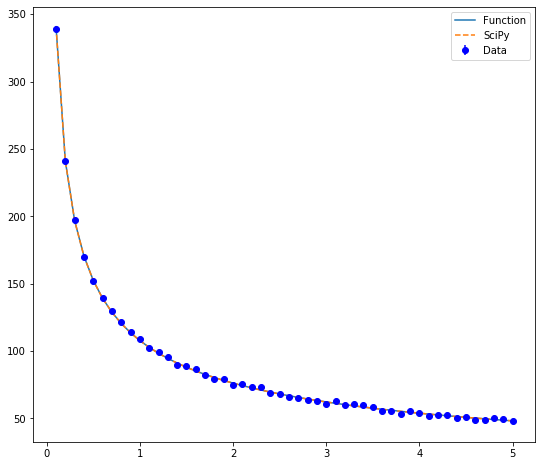

In [21]:
#Plotting
fig = plt.figure(figsize=(9.0,8.0))

plt.errorbar(rdata,ydata,yerr=sigdata,fmt='bo',label='Data')
plt.plot(rdata,ycurve,label='Function')
plt.plot(rdata,s_curve,linestyle='--',label='SciPy')

plt.legend()
plt.show()

Our values don't seem to be too bad. Let's keep going and see how lmfit handles this fit.

In [22]:
#Setup
l_mod = lf.Model(v)
params = l_mod.make_params(G=4.3e-6,M=2.7e9)

#Do fit
l_fit = l_mod.fit(ydata, params, r=rdata, weights=weighdata)

#Define Stuff
l_dict = l_fit.best_values
l_G = l_dict['G']
l_M = l_dict['M']

#Create array to plot
l_curve = np.sqrt(l_G*l_M/rdata)

l_fit #Display information about the fit

ValueError: The input contains nan values

It seems lmfit won't run at all; it's getting nan (not-a-number) values, most likely from the same place that scipy got its runtime warning. 
In this sense, scipy seems to be a bit more robust.

Let's see how this goes if we do a new run of the code with bounds that prevent the bad square root values.

In [ ]:
#Initial Guesses
#p0 = [4.3e-6,2.7e9] #These should be the same, so no need to redefine them.
bounds = [0,np.inf]

#Do fit
s_fit = opt.curve_fit(v,rdata,ydata,p0,bounds=bounds,sigma=sigdata,absolute_sigma=True)

#Define parameters from fit.
s_G = s_fit[0][0]
s_M = s_fit[0][1]

#Define error from fit.
s_cov = s_fit[1]
s_error = np.sqrt(np.diag(s_cov))
s_Ge = s_error[0]
s_Me = s_error[1]

#Create array to plot
s_curve = np.sqrt(s_G*s_M/rdata)

#Print Values
print('G: '+str(s_G)+u' \u00B1 '+str(s_Ge))
print('M: '+str(s_M)+u' \u00B1 '+str(s_Me))

These errors are low -- one might even say unreasonably low. 
But, we did say that all of our errors were exactly 1, which is much less than would probably be realistic for most of our measurements.

In [23]:
#Setup
#weighdata = 1/sigdata #Already defined above -- no need to redefine it.
l_mod = lf.Model(v)
params = l_mod.make_params()         #Because we want to limit our parameters, we will have to add them after this line, rather than creating them initially.
params.add('G', value=4.3e-6, min=0) #"min=0" tells lmfit that the parameter should never be checked below the value 0.
params.add('M', value=2.7e9, min=0)

#Do fit
l_fit = l_mod.fit(ydata, params, r=rdata, weights=weighdata, nan_policy='omit')

#Define Stuff
l_dict = l_fit.best_values
l_G = l_dict['G']
l_M = l_dict['M']

#Create array to plot
l_curve = np.sqrt(l_G*l_M/rdata)

l_fit

Lmfit ran this time, excellent!
However, we're getting nan values for our errors. In a sense, this could be correct.
Recall that we were fitting for two values multiplied by one another. 
This means that, really, either value could be anything -- the only thing we really can fit for is the product of the two.
Let's test that hypothesis by fitting their multiple directly.

In [24]:
#Re-create function. Our data doesn't need to change since GM = G*M
def v(r,GM): #One variable for GM
    return np.sqrt(GM/r)

#Setup
l_mod = lf.Model(v)
params = l_mod.make_params()
params.add('GM', value=4.3e-6*2.7e9, min=0) #Here is our new, singular parameter

#Do fit
l_fit = l_mod.fit(ydata, params, r=rdata, weights=weighdata, nan_policy='omit')

#Define Stuff
l_dict = l_fit.best_values
l_GM = l_dict['GM'] #updating fit to use correct information

#Create array to plot
l_GMcurve = np.sqrt(l_GM/rdata)

l_fit

We got real values for our fits! Now let's plot everything and see how it turned out.

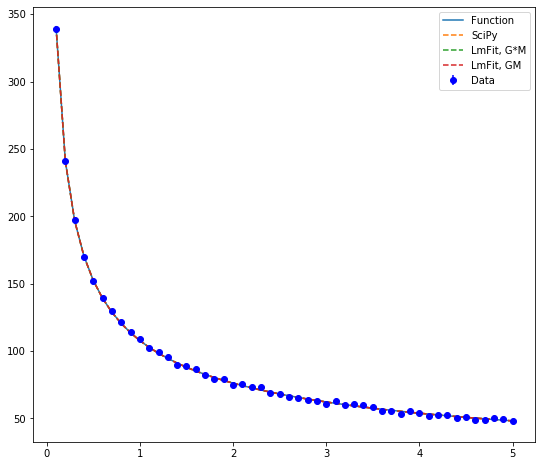

In [28]:
#Plotting

fig = plt.figure(figsize=(9.0,8.0))

plt.errorbar(rdata,ydata,yerr=sigdata,fmt='bo',label='Data')
plt.plot(rdata,ycurve,label='Function')
plt.plot(rdata,s_curve,linestyle='--',label='SciPy')
plt.plot(rdata,l_curve,linestyle='--',label='LmFit, G*M')   #original method for the fit
plt.plot(rdata,l_GMcurve,linestyle='--',label='LmFit, GM') #one-variable method

plt.legend()
plt.show()

And we once again see that all of our fits are stacked neatly atop the true curve.